In [1]:
#Trabalho Final CMP197 
#FABIO U.P.
#Segmentação Panóptica Imagens de Satéllite Pivô 
#Gerador de NDVI e cropador de imagens

import os
from glob import glob
import numpy as np
import matplotlib.image as plti
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import geopandas as gpd
import rasterio as rio
from rasterio import plot
from rasterio.plot import plotting_extent
%matplotlib inline

In [2]:
#import bandas como layers separados
#TESTE_1
path = "C:/Users/ugald/OneDrive/00_UFRGS/03_ComputerVision/TrabalhoFinal/T11SQS_20220407T180909_"  #IMAGEM SOMENTE PIVOTS 1
band2 = rio.open(path +'B02.jp2', driver='JP2OpenJPEG') #blue
band3 = rio.open(path +'B03.jp2', driver='JP2OpenJPEG') #green
band4 = rio.open(path +'B04.jp2', driver='JP2OpenJPEG') #red
band8 = rio.open(path +'B08.jp2', driver='JP2OpenJPEG') #nir


In [3]:
#CONVERSÕES JP2 - TIFF
#JP2 to geoTIFF - BLUE
blue_tiff = rio.open('C:/Users/ugald/OneDrive/00_UFRGS/03_ComputerVision/TrabalhoFinal/bluet.tiff','w',driver='Gtiff',
                         width=band2.width, height=band2.height,
                         count=1,
                         crs=band2.crs,
                         transform=band2.transform,
                         dtype=band2.dtypes[0]
                         )

blue_tiff.write(band2.read(1),1) #blue
blue_tiff.close()

# #JP2 to geoTIFF - GREEN
green_tiff = rio.open('C:/Users/ugald/OneDrive/00_UFRGS/03_ComputerVision/TrabalhoFinal/greent.tiff','w',driver='Gtiff',
                         width=band3.width, height=band3.height,
                         count=1,
                         crs=band3.crs,
                         transform=band3.transform,
                         dtype=band3.dtypes[0]
                         )

green_tiff.write(band3.read(1),1) #blue
green_tiff.close()

# #JP2 to geoTIFF - RED
red_tiff = rio.open('C:/Users/ugald/OneDrive/00_UFRGS/03_ComputerVision/TrabalhoFinal/redt.tiff','w',driver='Gtiff',
                         width=band4.width, height=band4.height,
                         count=1,
                         crs=band4.crs,
                         transform=band4.transform,
                         dtype=band4.dtypes[0]
                         )

red_tiff.write(band4.read(1),1) #blue
red_tiff.close()

# #JP2 to geoTIFF - NIR
nir_tiff = rio.open('C:/Users/ugald/OneDrive/00_UFRGS/03_ComputerVision/TrabalhoFinal/NIRt.tiff','w',driver='Gtiff',
                         width=band8.width, height=band8.height,
                         count=1,
                         crs=band8.crs,
                         transform=band8.transform,
                         dtype=band8.dtypes[0]
                         )

nir_tiff.write(band2.read(1),1) #blue
nir_tiff.close()

In [4]:
#ABRE IMAGENS RECEM GERADAS EM TIFF
path2 = "C:/Users/ugald/OneDrive/00_UFRGS/03_ComputerVision/TrabalhoFinal/"
bands = glob(path2 + "*t.tiff")
bands.sort()
bands
len(bands) # Numero de Bandas

4

In [5]:
output_dir = "C:/Users/ugald/OneDrive/00_UFRGS/03_ComputerVision/TrabalhoFinal/"
if os.path.isdir(output_dir) == False:
    os.mkdir(output_dir)

#raster_out_path = os.path.join(output_dir, "raster.tiff")

In [6]:
#EMPILHA CAMADAS
os.chdir(os.path.join(et.io.HOME, "earth-analytics"))
#out_path=raster_out_path    
array_stack, raster_prof = es.stack(bands, nodata=-9999)

In [7]:
extent = plotting_extent(array_stack[0], raster_prof["transform"])

In [8]:
#Abre shapefile usando GeoPandas
crop_bound = gpd.read_file("C:/Users/ugald/OneDrive/00_UFRGS/03_ComputerVision/TrabalhoFinal/Shapefiles/YUMA_VALLEY_AZ_CMP197.shx")

In [9]:
#DEFINE CRS DO SHAPEFILE
crop_bound = crop_bound.set_crs(epsg=4326)
print(crop_bound.crs)

epsg:4326


In [10]:
#IGUALA CRS
os.environ["PROJ_LIB"] = r"C:/Users/ugald/anaconda3/envs/earth-analytics-python/share"
os.chdir(os.path.join(et.io.HOME, "earth-analytics"))

with rio.open(bands[0]) as raster_crs:
    crop_raster_profile = raster_crs.profile
    crop_bound_utm11N = crop_bound.to_crs(crop_raster_profile["crs"])

In [11]:
#CROPA IMAGEM
os.chdir(os.path.join(et.io.HOME, "earth-analytics"))

band_paths_list = es.crop_all(bands, output_dir, crop_bound_utm11N, overwrite=True)

C:\Users\ugald\anaconda3\envs\earth-analytics-python\lib\site-packages\numpy\lib\function_base.py:4650: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


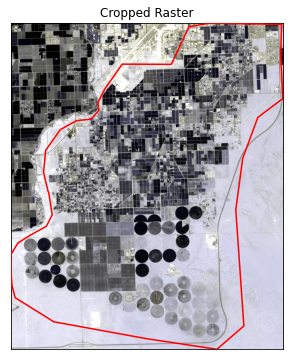

In [12]:
#MOSTRA IMAGEM CROPADA COM SHP
os.chdir(os.path.join(et.io.HOME, "earth-analytics"))

cropped_array, array_raster_profile = es.stack(band_paths_list, nodata=-9999)
crop_extent = plotting_extent(cropped_array[0], array_raster_profile["transform"])

# Plotting the cropped image
# sphinx_gallery_thumbnail_number = 5
fig, ax = plt.subplots(figsize=(12, 6))
crop_bound_utm11N.boundary.plot(ax=ax, color="red", zorder=10)
ep.plot_rgb(
    cropped_array,
    ax=ax,
    stretch=True,
    extent=crop_extent,
    title="Cropped Raster"
)
plt.show()

In [13]:
#CALCULA NDVI
ndvi = es.normalized_diff(cropped_array[3], cropped_array[2])

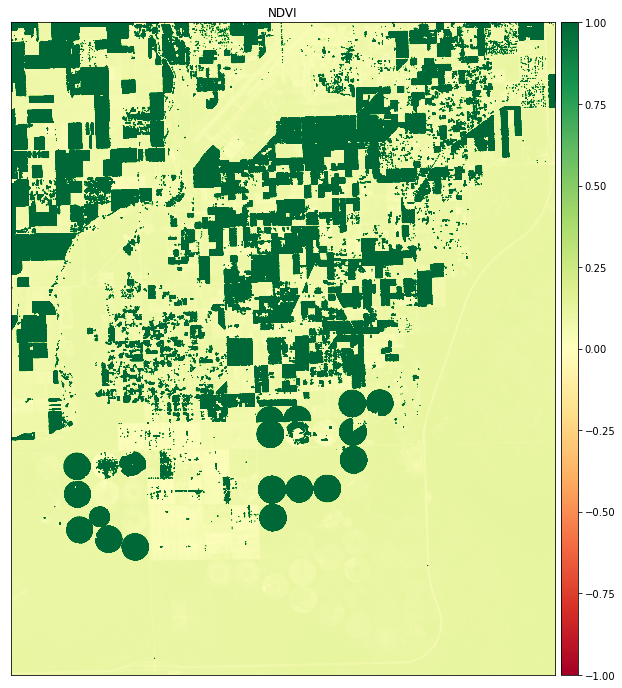

<AxesSubplot:title={'center':'NDVI'}>

In [14]:
#MOSTRA NDVI CROPADO
titles = ["NDVI"]

# Turn off bytescale scaling due to float values for NDVI
ep.plot_bands(ndvi, cmap="RdYlGn", cols=1, title=titles, vmin=-1, vmax=1)

In [15]:
#Salva imagem NDVI EM TIFF PRA USAR COM OPENCV DEPOIS
ndvi_tiff = rio.open('C:/Users/ugald/OneDrive/00_UFRGS/03_ComputerVision/TrabalhoFinal/YUMA_VALLEY_TESTE.tiff','w',driver='Gtiff',
                         width=band8.width, height=band8.height,
                         count=1,
                         crs=band8.crs,
                         transform=band8.transform,
                         dtype=rio.float32
                         )

ndvi_tiff.write(ndvi, 1) #ndvi
ndvi_tiff.close()

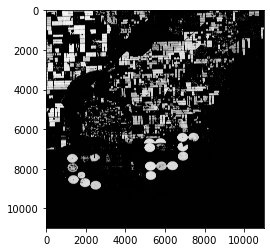

In [16]:
#MOSTRA IMAGEM SALVA
fp = r'C:/Users/ugald/OneDrive/00_UFRGS/03_ComputerVision/TrabalhoFinal/YUMA_VALLEY_TESTE.tiff'
img = rio.open(fp)
plt.imshow(img.read(1), cmap="gray")
plt.show()

In [17]:
#SALVA IMAGEM EM PNG
plti.imsave('C:/Users/ugald/OneDrive/00_UFRGS/03_ComputerVision/TrabalhoFinal/YUMA_VALLEY_TESTE.png', ndvi)

In [18]:
#NORMALIZA VALORES ENTRE 0 e 255
max_ndvi = ndvi.max()
min_ndvi = ndvi.min()
ndvi_norm = []

for i in range(0, len(ndvi)):
  temp = 255 * ((ndvi[i] - min_ndvi)/(max_ndvi -  min_ndvi))
  ndvi_norm.append(temp)

In [19]:
#SALVA IMAGEM CROPADA DE NDVI NORMALIZADO
ndvi_norm = np.array(ndvi_norm)
plti.imsave('C:/Users/ugald/OneDrive/00_UFRGS/03_ComputerVision/TrabalhoFinal/YUMA_VALLEY_TESTE.png', ndvi)